<a href="https://colab.research.google.com/github/johansB08/labsSeminario/blob/main/Lab3_cars_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cars price prediction
Johan Steven Benavides Guarnizo - 88593

Sebastian Morales Devia - 73487



The objective of this jupyter notebook is to train a machine learning algorithm to predict a car's price, based on known characteristics. The training data was obtained by web scraping, using Selenium and Beautiful Soap from tucarro.com.co; This project has no commercial purposes its for merely academic endeavor.
_Updated: June 22th, 2024_

## Data understanding

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

### Load data

In [4]:
cols = ['model','price','year','kms','color','fueltype']
data = pd.read_csv('/content/drive/MyDrive/SeminarioB/taller3/usedCarsCol_logan_200624.csv', sep=',', names=cols, header=0, encoding='latin-1')
print(data.shape)
data.head()


(432, 6)


,model,price,year,kms,color,fueltype
0,Renault Logan Dinamique 1.6 Fe Mt,$19.500.000,2007,86.000,Plateado,Gasolina
1,Renault Logan Expression mecÃ¡nico,$34.500.000,2018,93.500,Plateado,Gasolina
2,Renault Logan AUTHENTIQUE 1600CC MT AA,$30.500.000,2016,75.200,Plateado,Gasolina
3,Renault Logan Familier 1400cc Mt Aa,$27.000.000,2014,156.450,Gris,Gasolina
4,Renault Logan AUTHENTIQUE 1600CC MT AA,$34.000.000,2016,102.685,Negro,Gasolina


### Verify data types

In [5]:
data.dtypes

model       object
price       object
year         int64
kms         object
color       object
fueltype    object
dtype: object

### Count unique values for each variable

In [6]:
data.nunique()

model       129
price       193
year         20
kms         300
color        11
fueltype      2
dtype: int64

In [7]:
print(data['model'].unique().tolist())
print(data['price'].unique().tolist())
print(data['year'].unique().tolist())
print(data['kms'].unique().tolist())
print(data['color'].unique().tolist())
print(data['fueltype'].unique().tolist())

['Renault Logan Dinamique 1.6 Fe Mt', 'Renault Logan Expression mecÃ¡nico', 'Renault Logan AUTHENTIQUE  1600CC MT AA', 'Renault Logan Familier  1400cc Mt Aa', 'Renault Logan Life 1.6 Mecanico Sedan', 'Renault Logan Expression Night & Day  1600cc Mt Aa', 'Renault Logan Privilege 1.6cc AT AA 4X2', 'Renault Logan 1.6 Expression', 'Renault Logan 1.6 Authentique / Life', 'Renault Logan Familier  1400cc Mt', 'Renault Logan Exclusive  1600cc At Aa', 'Renault Logan Exclusive 1.6 At Sedan Ejl868', 'Renault Logan 1.6 Authentique', 'Renault Logan Life +', 'Renault Logan Life 1.6 2023 Mq', 'Renault Logan 1.6 Life', 'Renault Logan 1.6 Expression Fii', 'Renault Logan Aut 16v Motor Intens 110hp Divino Financiamos', 'Logan Zen. Full Equipo 2023 Motor 1.6  4 Airbag  Rin De Lujo', 'Renault Logan Polar 1.6', 'Renault Logan 1.6 Privilege / Intens', 'Taxi Intermunicipal Renault Logan Dynamique 2014', 'Renault Logan 1.6 Dynamique Fii', 'Renault Logan Mt 2023', 'Renault Logan LIFE 1.6', 'Renault Logan 1.4 En

### Data transformation

In [8]:
# Copy data and remove model variable
datacc = data
datacc = datacc.drop(['model'], axis=1)
datacc.shape

(432, 5)

#### Transform $price$ to numerical

In [9]:
datacc['price'] = datacc['price'].str.replace(r'[$.]', '', regex=True).astype(int)

##### Transform $kms$ to numerical

In [11]:
# Convert 'kms' column to string type before applying str.replace
datacc['kms'] = datacc['kms'].astype(str).str.replace(r'[.]', '',regex=True)
# Identify non-numeric values
non_numeric = datacc[pd.to_numeric(datacc['kms'], errors='coerce').isna()]
print(non_numeric)
#Decide how to handle non-numeric values, for example replace with 0
datacc['kms'] = pd.to_numeric(datacc['kms'], errors='coerce').fillna(0).astype(int)

        price  year        kms     color  fueltype
212  30900000  2017  Publicado  Plateado  Gasolina


In [12]:
datacc.replace({'kms': {'Publicado': 0}}, inplace=True)

In [13]:
datacc['kms'] = datacc['kms'].replace('[.]','',regex=True).astype(int)

##### Transform categorical variables to dummies: $year$ and $fuel type$

In [14]:
# Object to categorical
datacc['color'] = datacc['color'].astype('category')
datacc['fueltype'] = datacc['fueltype'].astype('category')
datacc.dtypes

price          int64
year           int64
kms            int64
color       category
fueltype    category
dtype: object

In [15]:
# Convert to dummies
# Convert category to codes
datacc['color']  = pd.Categorical(datacc['color']).codes
datacc['fueltype']  = pd.Categorical(datacc['fueltype']).codes
datacc.head()

,price,year,kms,color,fueltype
0,19500000,2007,86000,8,0
1,34500000,2018,93500,8,0
2,30500000,2016,75200,8,0
3,27000000,2014,156450,5,0
4,34000000,2016,102685,7,0


## Data Exploration

In [16]:
# Descriptive statistics
datacc.describe()[['price','year','kms']]

,price,year,kms
count,4.320000e+02,432.000000,432.000000
mean,3.962780e+07,2018.034722,72715.030093
std,1.196959e+07,4.597104,63266.999037
min,1.670000e+07,2000.000000,0.000000
25%,3.000000e+07,2015.000000,36000.000000
50%,3.894950e+07,2019.000000,62702.000000
75%,4.899250e+07,2022.000000,96245.000000
max,7.393000e+07,2024.000000,924800.000000


#### Histograms

Text(0.5, 1.0, '$kms$')

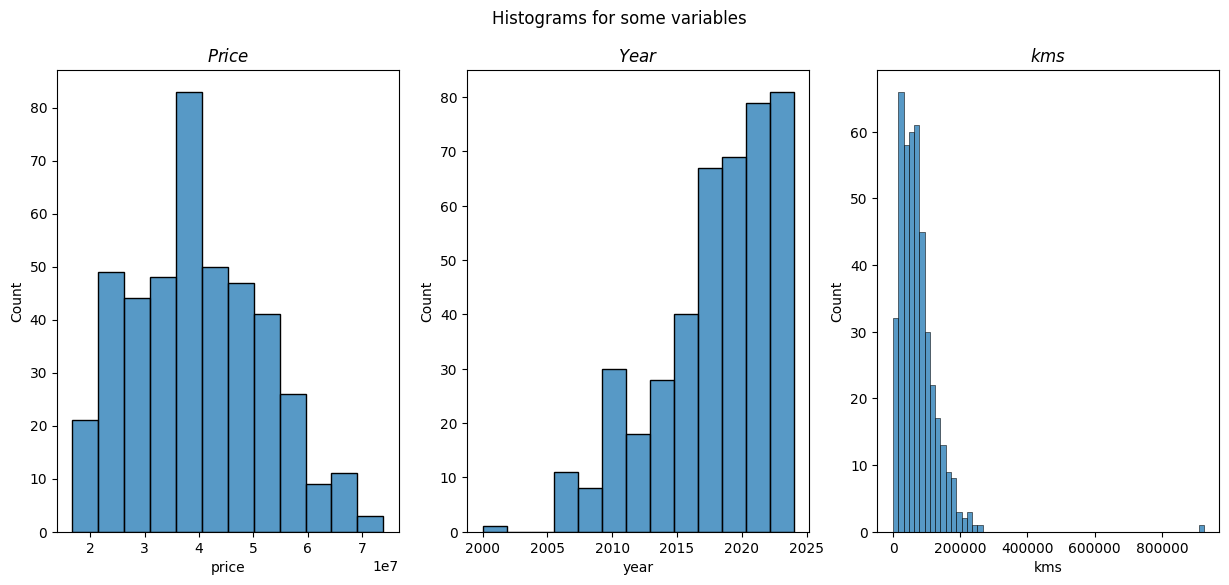

In [17]:
# Histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
fig.suptitle('Histograms for some variables')
sns.histplot(datacc['price'], ax=ax1)
ax1.set_title('$Price$')
sns.histplot(datacc['year'], ax=ax2)
ax2.set_title('$Year$')
sns.histplot(datacc['kms'], ax=ax3)
ax3.set_title('$kms$')

#### Boxplots

<Axes: >

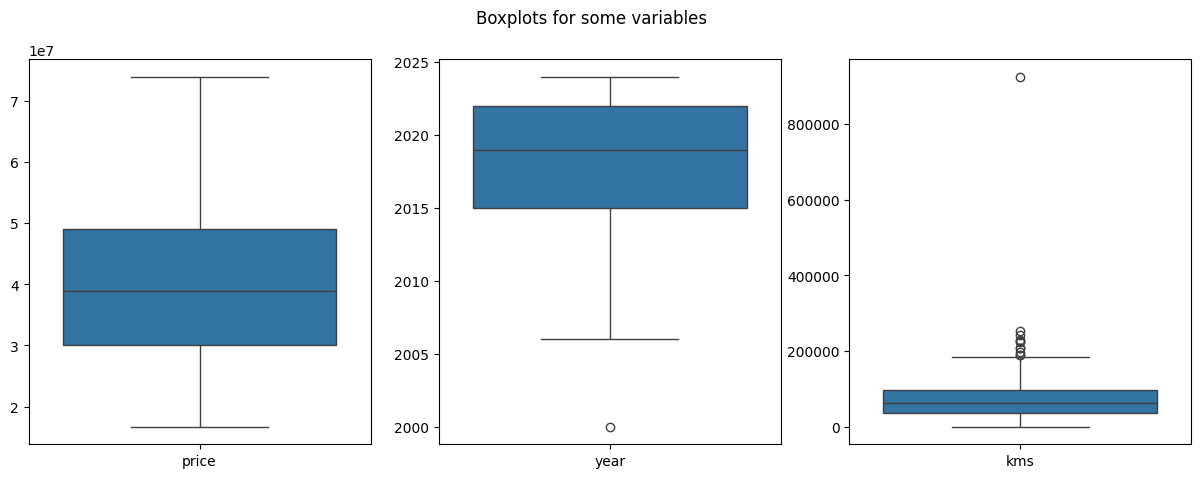

In [18]:
### Boxplot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Boxplots for some variables')
sns.boxplot(data=datacc[['price']], ax=ax1)
sns.boxplot(data=datacc[['year']], ax=ax2)
sns.boxplot(data=datacc[['kms']], ax=ax3)

#### Ouliers treatment
_https://www.statology.org/remove-outliers-python/_  
_https://towardsdatascience.com/a-complete-guide-for-detecting-and-dealing-with-outliers-bad26b1e92b6_  
_https://www.scribbr.com/statistics/outliers/_  
_https://www.statology.org/remove-outliers/_  

<Axes: >

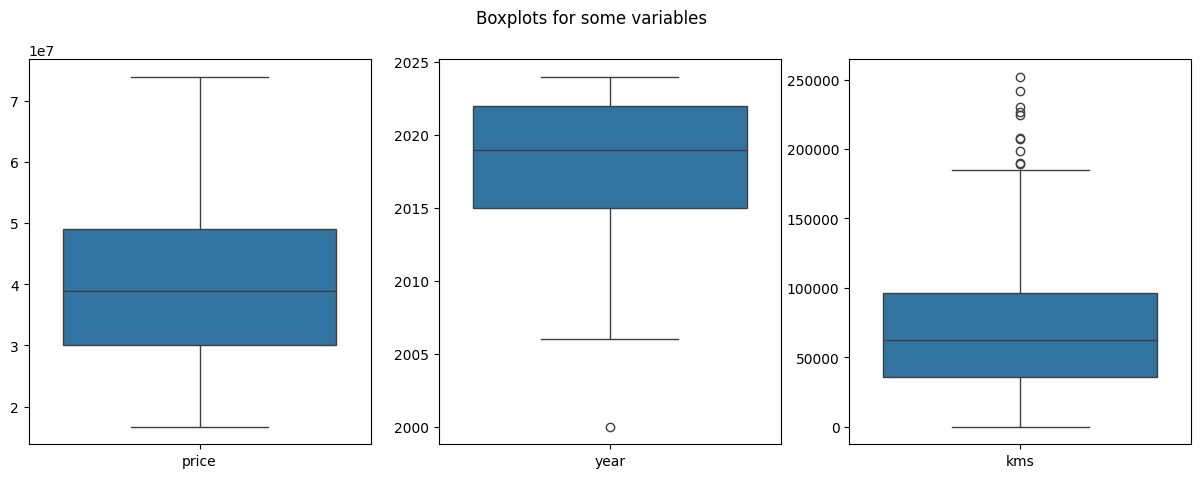

In [19]:
# Z score to eliminate outliers of 'year' and 'kms'
from scipy import stats

#find absolute value of z-score for each observation of 'kms'
z2 = np.abs(stats.zscore(datacc['kms']))

#only keep rows in dataframe with all z-scores less than absolute value of 3
toremove = datacc.kms[(z2>3)].index
datacc = datacc.drop(toremove)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Boxplots for some variables')
sns.boxplot(data=datacc[['price']], ax=ax1)
sns.boxplot(data=datacc[['year']], ax=ax2)
sns.boxplot(data=datacc[['kms']], ax=ax3)

Text(0.5, 1.0, '$kms$')

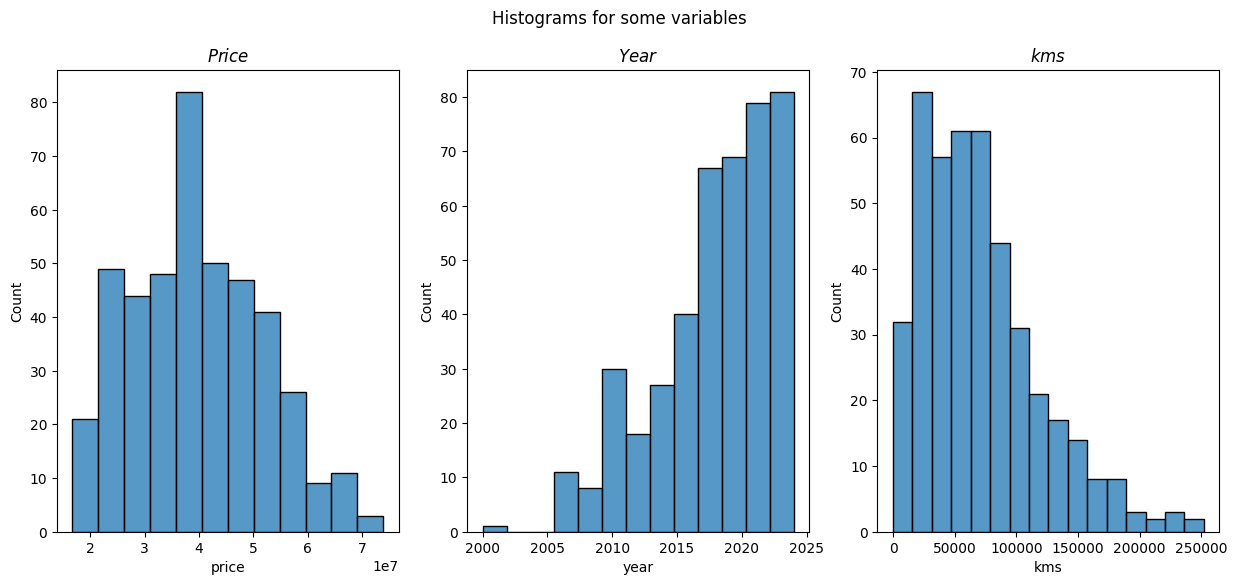

In [20]:
# Histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
fig.suptitle('Histograms for some variables')
sns.histplot(datacc['price'], ax=ax1)
ax1.set_title('$Price$')
sns.histplot(datacc['year'], ax=ax2)
ax2.set_title('$Year$')
sns.histplot(datacc['kms'], ax=ax3)
ax3.set_title('$kms$')

##Pruebas

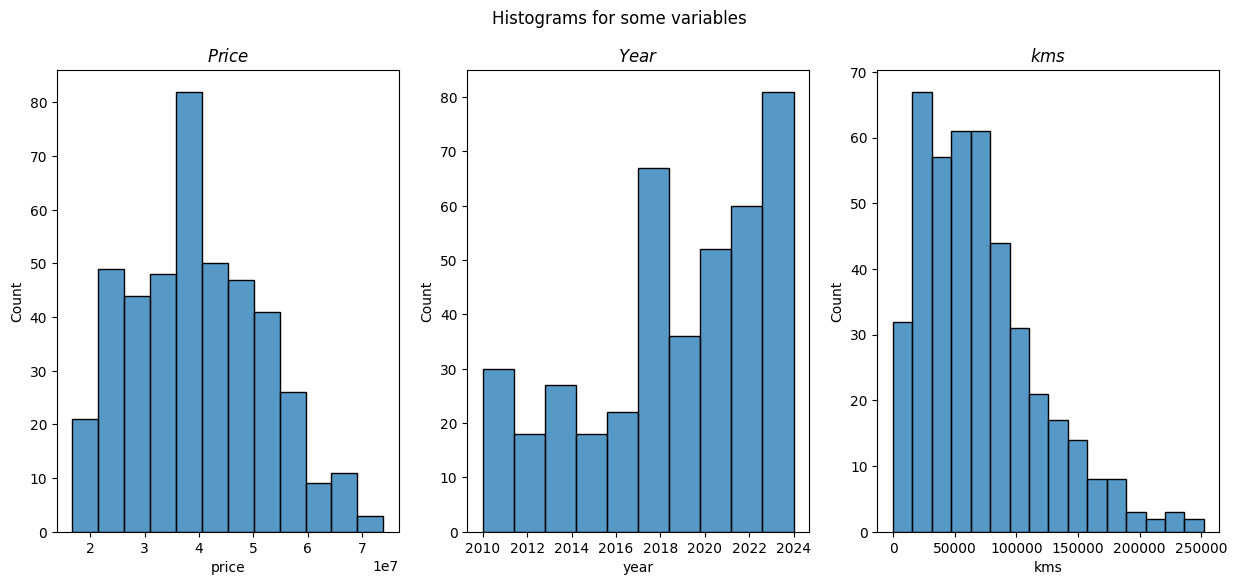

In [21]:
#filtración por año
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que 'datacc' es tu DataFrame donde tienes las variables 'price', 'year' y 'kms'

# Filtro para los datos de 'year' entre 2010 y 2025
filtered_data = datacc[(datacc['year'] >= 2010) & (datacc['year'] <= 2025)]

# Histogramas
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
fig.suptitle('Histograms for some variables')

# Histograma para 'price'
sns.histplot(datacc['price'], ax=ax1)
ax1.set_title('$Price$')

# Histograma para 'year' con filtro
sns.histplot(filtered_data['year'], ax=ax2)
ax2.set_title('$Year$')

# Histograma para 'kms'
sns.histplot(datacc['kms'], ax=ax3)
ax3.set_title('$kms$')

plt.show()

### EDA (Exploratory Data Analysis)

#### Correlations

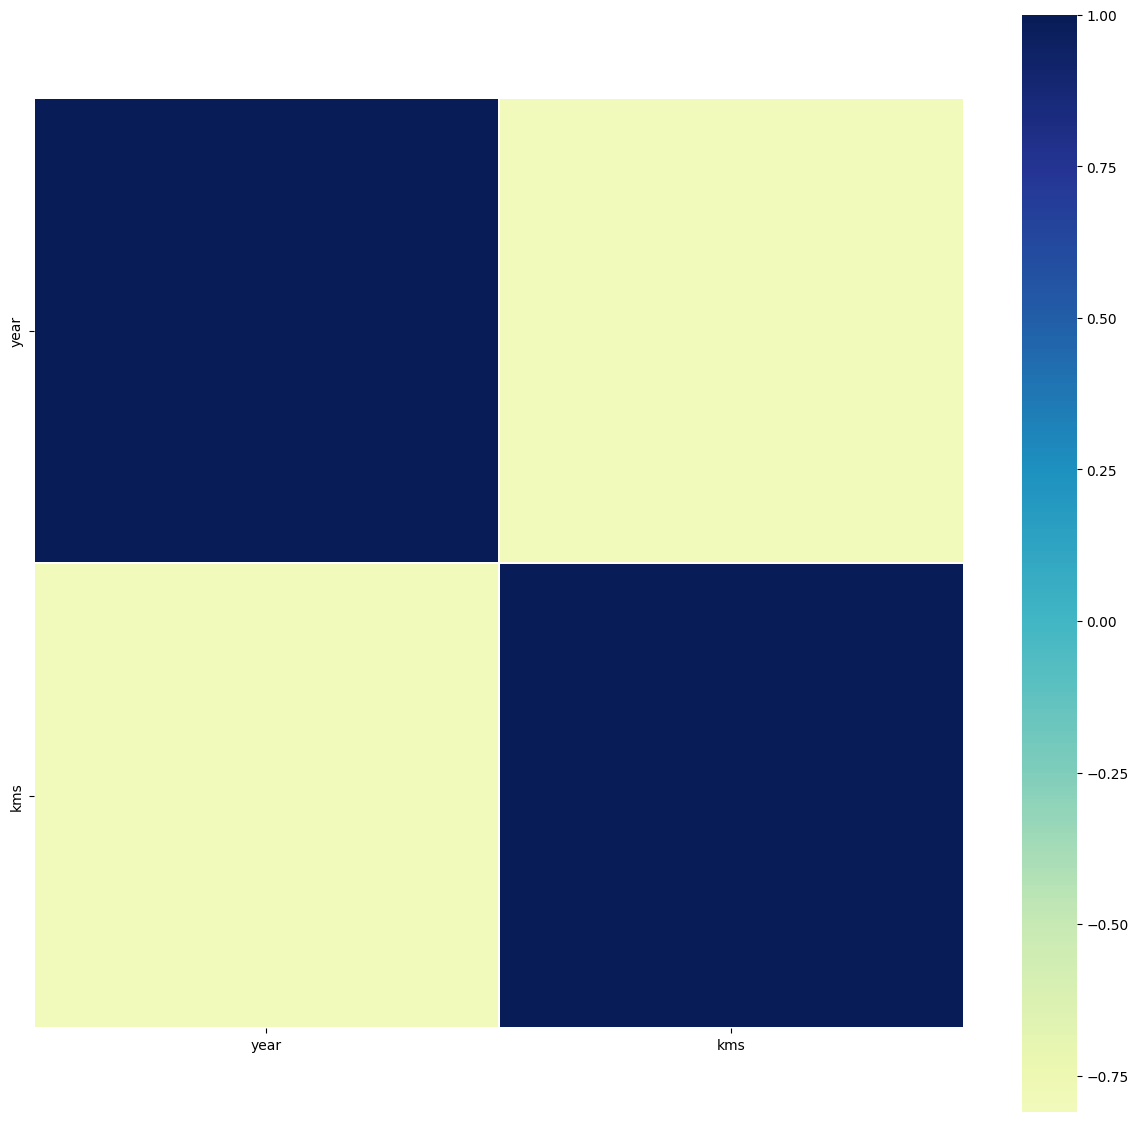

In [22]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.2, annot=False, cbar_kws={"shrink": .95}
                )
    plt.show();

# Use the 'datacc' DataFrame instead of 'X'
correlation_heatmap(datacc[['year', 'kms']]) # Call the function with the correct DataFrame

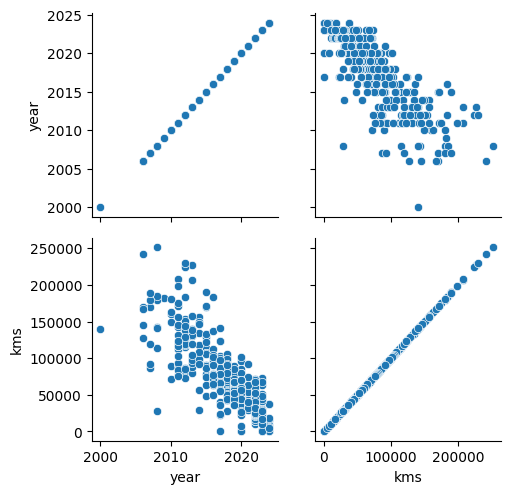

In [23]:
# Assuming 'datacc' is the DataFrame you want to use
g = sns.PairGrid(datacc[['year', 'kms']])
g.map(sns.scatterplot)

## Modeling: machine learning

### Libraries

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE, r2_score
from sklearn.metrics import mean_absolute_error as MAE
import pickle

### Data partitioning


In [25]:
X = datacc.copy()
X = X.drop(['price'], axis=1)
print(X.shape)

Y = pd.DataFrame()
Y = datacc['price']
print(Y.shape)

(431, 4)
(431,)


In [26]:
# Data set normalization and partitioning
#Normalización de datos, se debe hacer
sc = StandardScaler()
Xsc = sc.fit(X)
Xt = Xsc.transform(X)
Xt.shape

(431, 4)

In [27]:
#aca se hace el particionamiento de los datos, aca se tiene el 20 % de los datos apra evaluación
X_train, X_test, y_train, y_test = split(Xt,Y,
                                         test_size=0.20,
                                         random_state=42)

### Multivariate lineal regression

In [28]:
# Define model and prediction
ols = LinearRegression()
model1 = ols.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

In [29]:
# accuracy check
rmse = MSE(y_test, y_pred1, squared=False)
mae = MAE(y_test, y_pred1)
r2 = r2_score(y_test, y_pred1)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 5077627.27
MAE: 3977357.39
R2: 0.80


### Light GBM
https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/   
https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html  

In [30]:
!pip install lightgbm

In [31]:
import lightgbm as lgb

In [32]:
# Hyperparameters
params = {
    'task': 'train',
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 3,
    'learning_rate': 1.510,
    'metric': {'l2','l1'},
    'header' : 'true',
    'verbose': 0
}

# laoding data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# fitting the model
model2 = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)
# Pred
y_pred2 = model2.predict(X_test)

In [33]:
# accuracy check
rmse = MSE(y_test, y_pred2, squared=False)
mae = MAE(y_test, y_pred2)
r2 = r2_score(y_test, y_pred2)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 5765985.19
MAE: 4220843.46
R2: 0.74


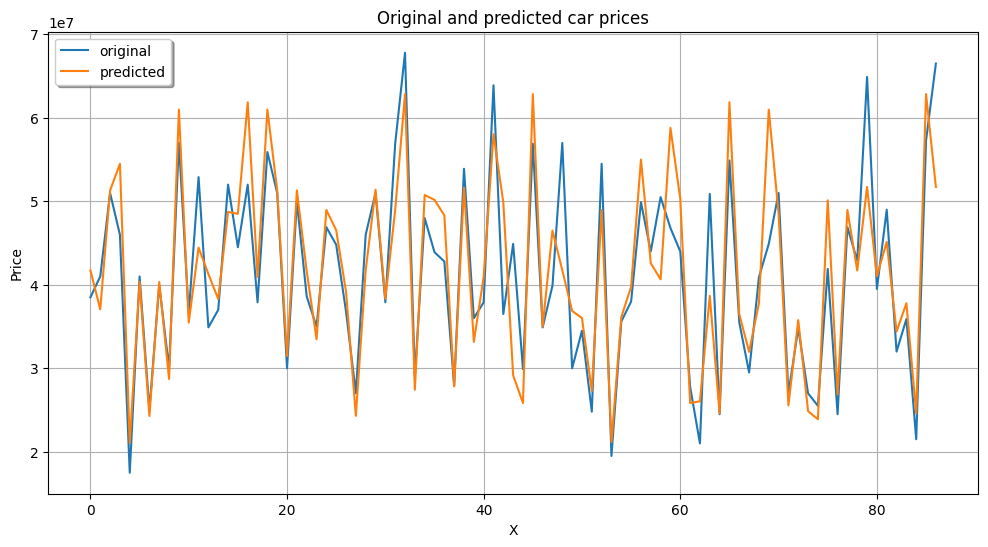

In [34]:
# visualizing in a plot
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred2, label="predicted")
plt.title("Original and predicted car prices")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show()

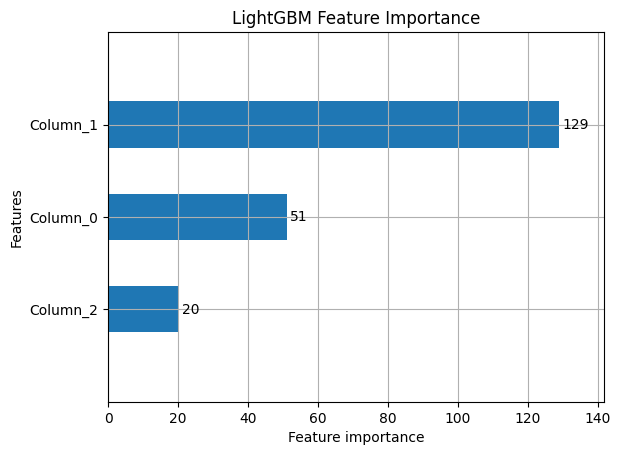

In [35]:
# plotting feature importance
ax = lgb.plot_importance(model2, height=.5, title="LightGBM Feature Importance")


<Axes: >

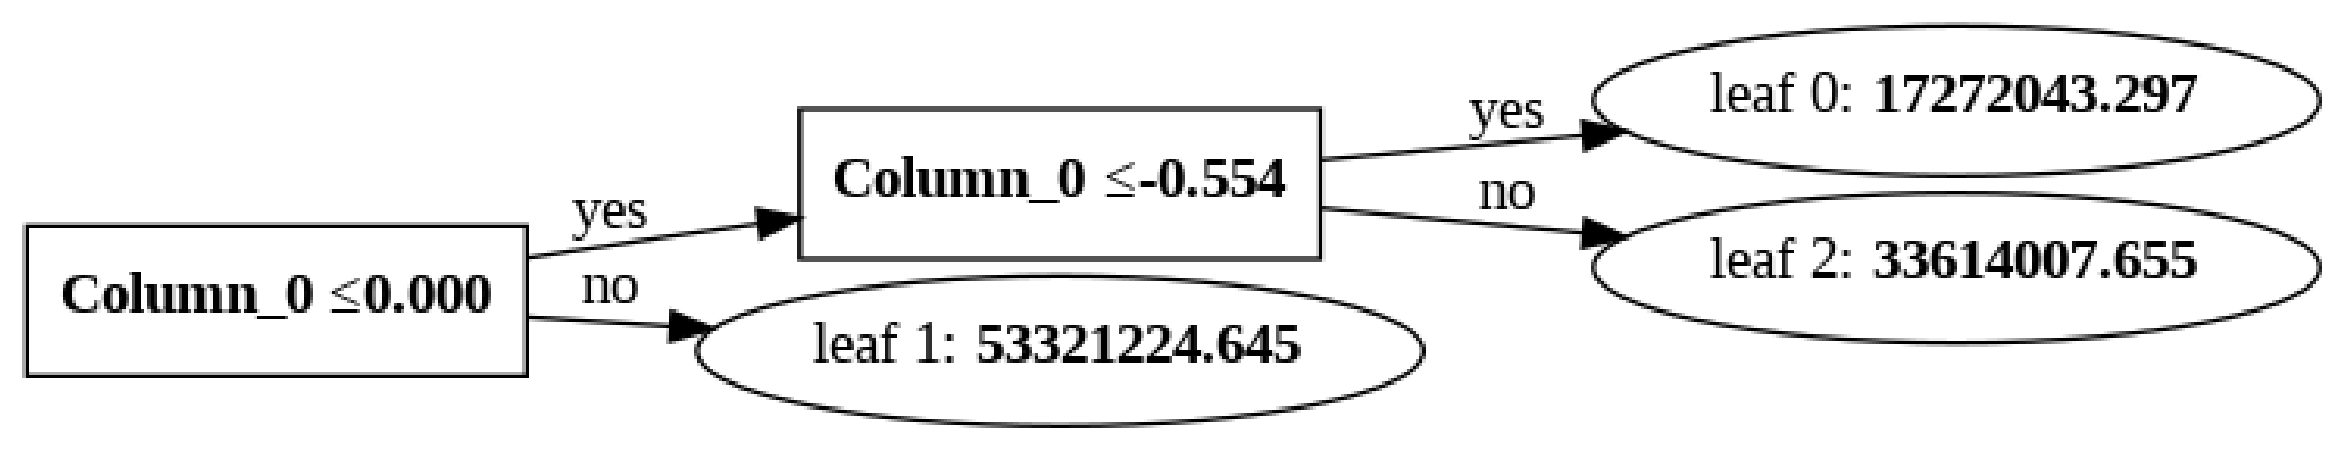

In [36]:
lgb.plot_tree(model2,figsize=(30,40))

### Random Forest Regressor

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
model3 = RandomForestRegressor()
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

In [39]:
# accuracy check
rmse = MSE(y_test, y_pred3, squared=False)
mae = MAE(y_test, y_pred3)
r2 = r2_score(y_test, y_pred3)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 5142115.01
MAE: 3658403.07
R2: 0.80


**Save the model**

In [40]:
with open('model3.pkl', 'wb') as f:
  pickle.dump(model3, f)

### Xgboost regressor
https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

In [41]:
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from sklearn.metrics import classification_report

In [42]:
#Define model
model4 = xgb.XGBRegressor(objective ='reg:squarederror',
                          booster='gbtree',
                          colsample_bytree = 1,
                          importance_type='gain',
                          learning_rate = 0.2,
                          max_depth = 5,
                          alpha = 5,
                          n_estimators = 200,
                          seed=123)

In [43]:
#Training
model4.fit(X_train, y_train)#,
#         eval_set=[(X_train, y_train), (X_test, y_test)], \
#         eval_metric='mlogloss', verbose=False)

XGBRegressor(alpha=5, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
#K-fold cross validation
scores = cross_val_score(model4, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.79


In [45]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model4, X_train, y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.81


In [46]:
# Pred
y_pred4 = model4.predict(X_test)

In [47]:
# accuracy check
rmse = MSE(y_test, y_pred4, squared=False)
mae = MAE(y_test, y_pred4)
r2 = r2_score(y_test, y_pred4)
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("R2: %.2f" % r2)

RMSE: 6114098.81
MAE: 4330822.91
R2: 0.71


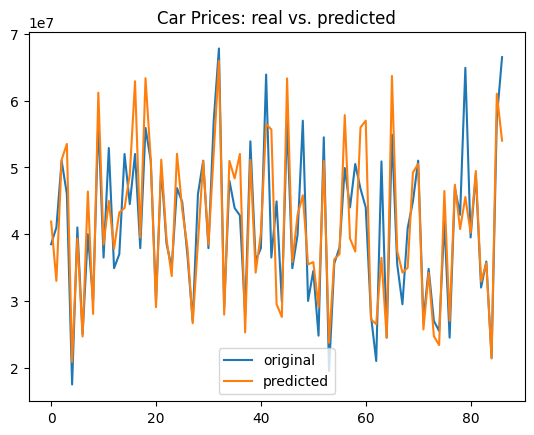

In [48]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred4, label="predicted")
plt.title("Car Prices: real vs. predicted")
plt.legend()
plt.show()